In [1]:
#We will make a basic CNN model to classify CIFAR-10#
#We will use Keras from Tensorflow to build the model#

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import SparseTopKCategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import datetime

#show the tensorflow version
print(tf.__version__)


2.10.1


In [2]:
#Test if have GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12910347680097356717
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5713690624
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14316871063850945321
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9"
xla_global_id: 416903419
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
#load the CIFAR-100 dataset & split into train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#Normalize pixel values from 1-255 to 0-1
x_train, x_test = x_train / 255.0, x_test / 255.0

#show the shape of the dataset
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape) 

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)


In [4]:
#shuffle train & test data

# # Assuming x_train and y_train are your data
# indices = np.arange(x_train.shape[0])
# np.random.shuffle(indices)

# # Let's say we want to select 10000 random samples
# x_train_subset = x_train[indices[:10000]]
# y_train_subset = y_train[indices[:10000]]

In [5]:
#Build model

model = Sequential() #0

# Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Block 4
model.add(Flatten())
model.add(Dense(256, activation='relu'))

# Block 5
model.add(Dense(10, activation='softmax'))

# Print the model summary
model.summary()

#make four more identical models
model2 = keras.models.clone_model(model) #0.05
model3 = keras.models.clone_model(model) #0.1
model4 = keras.models.clone_model(model) #0.2
model5 = keras.models.clone_model(model) #0.5

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         7

In [6]:
# #Compile the model wiht label smoothing
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3)])
model2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.01),
              metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
model3.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.1),
                metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
model4.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.2),
                metrics=['accuracy', TopKCategoricalAccuracy(k=3)])
model5.compile(optimizer='adam',
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0.5),
                metrics=['accuracy', TopKCategoricalAccuracy(k=3)])

#Train the models
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[tensorboard_callback])
# one hot labels
y_train_1hot = tf.keras.utils.to_categorical(y_train, 10)
y_test_1hot = tf.keras.utils.to_categorical(y_test, 10)

history2 = model2.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history3 = model3.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history4 = model4.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])
history5 = model5.fit(x_train, y_train_1hot, epochs=20, validation_data=(x_test, y_test_1hot), callbacks=[tensorboard_callback])

#save loss & validation loss every 
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

train_loss4 = history4.history['loss']
val_loss4 = history4.history['val_loss']

train_loss5 = history5.history['loss']
val_loss5 = history5.history['val_loss']


Epoch 1/20
1563/1563 [==============================] - 16s 8ms/step - loss: 1.4908 - accuracy: 0.4463 - sparse_top_k_categorical_accuracy: 0.7678 - val_loss: 1.1247 - val_accuracy: 0.5920 - val_sparse_top_k_categorical_accuracy: 0.8719
Epoch 2/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.9855 - accuracy: 0.6480 - sparse_top_k_categorical_accuracy: 0.8978 - val_loss: 0.8901 - val_accuracy: 0.6915 - val_sparse_top_k_categorical_accuracy: 0.9105
Epoch 3/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.7855 - accuracy: 0.7220 - sparse_top_k_categorical_accuracy: 0.9314 - val_loss: 0.8163 - val_accuracy: 0.7126 - val_sparse_top_k_categorical_accuracy: 0.9277
Epoch 4/20
1563/1563 [==============================] - 11s 7ms/step - loss: 0.6578 - accuracy: 0.7693 - sparse_top_k_categorical_accuracy: 0.9487 - val_loss: 0.7772 - val_accuracy: 0.7317 - val_sparse_top_k_categorical_accuracy: 0.9349
Epoch 5/20
1563/1563 [==============================

c:\Users\MSI\anaconda3\envs\tf\lib\site-packages\keras\backend.py:5531: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1563/1563 [==============================] - 13s 8ms/step - loss: 1.5011 - accuracy: 0.4494 - top_k_categorical_accuracy: 0.7716 - val_loss: 1.1601 - val_accuracy: 0.6028 - val_top_k_categorical_accuracy: 0.8717
Epoch 2/20
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0047 - accuracy: 0.6577 - top_k_categorical_accuracy: 0.9025 - val_loss: 1.0072 - val_accuracy: 0.6597 - val_top_k_categorical_accuracy: 0.9057
Epoch 3/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8096 - accuracy: 0.7322 - top_k_categorical_accuracy: 0.9339 - val_loss: 0.8453 - val_accuracy: 0.7197 - val_top_k_categorical_accuracy: 0.9302
Epoch 4/20
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6948 - accuracy: 0.7785 - top_k_categorical_accuracy: 0.9494 - val_loss: 0.8350 - val_accuracy: 0.7324 - val_top_k_categorical_accuracy: 0.9322
Epoch 5/20
1563/1563 [==============================] - 12s 8ms/step - loss: 0.6077 - accuracy: 0.8071 - top_k_categori

In [8]:
#create a folder to save all these files
import os
if not os.path.exists('cifar10_cnn'):
    os.makedirs('cifar10_cnn')


#save the trained model (Parameters) so I can use it again without training again
model.save('cifar10_cnn.h5')
model2.save('cifar10_cnn2.h5')
model3.save('cifar10_cnn3.h5')
model4.save('cifar10_cnn4.h5')
model5.save('cifar10_cnn5.h5')

#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar10_cnn_weights.h5')
model2.save_weights('cifar10_cnn2_weights.h5')
model3.save_weights('cifar10_cnn3_weights.h5')
model4.save_weights('cifar10_cnn4_weights.h5')
model5.save_weights('cifar10_cnn5_weights.h5')

#save the histories (loss)
np.save('cifar10_cnn/train_loss_1.npy', train_loss)
np.save('cifar10_cnn/val_loss_1.npy', val_loss)

np.save('cifar10_cnn/train_loss_2.npy', train_loss2)
np.save('cifar10_cnn/val_loss_2.npy', val_loss2)

np.save('cifar10_cnn/train_loss_3.npy', train_loss3)
np.save('cifar10_cnn/val_loss_3.npy', val_loss3)

np.save('cifar10_cnn/train_loss_4.npy', train_loss4)
np.save('cifar10_cnn/val_loss_4.npy', val_loss4)

np.save('cifar10_cnn/train_loss_5.npy', train_loss5)
np.save('cifar10_cnn/val_loss_5.npy', val_loss5)


#save the accuracies
np.save('cifar10_cnn/acc_1.npy', history.history['accuracy'])
np.save('cifar10_cnn/val_acc_1.npy', history.history['val_accuracy'])

np.save('cifar10_cnn/acc_2.npy', history2.history['accuracy'])
np.save('cifar10_cnn/val_acc_2.npy', history2.history['val_accuracy'])

np.save('cifar10_cnn/acc_3.npy', history3.history['accuracy'])
np.save('cifar10_cnn/val_acc_3.npy', history3.history['val_accuracy'])

np.save('cifar10_cnn/acc_4.npy', history4.history['accuracy'])
np.save('cifar10_cnn/val_acc_4.npy', history4.history['val_accuracy'])

np.save('cifar10_cnn/acc_5.npy', history5.history['accuracy'])
np.save('cifar10_cnn/val_acc_5.npy', history5.history['val_accuracy'])

#save the top 3 accuracies
np.save('cifar10_cnn/top3_acc_1.npy', history.history['sparse_top_k_categorical_accuracy'])
np.save('cifar10_cnn/top3_val_acc_1.npy', history.history['val_sparse_top_k_categorical_accuracy'])

np.save('cifar10_cnn/top3_acc_2.npy', history2.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/top3_val_acc_2.npy', history2.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/top3_acc_3.npy', history3.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/top3_val_acc_3.npy', history3.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/top3_acc_4.npy', history4.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/top3_val_acc_4.npy', history4.history['val_top_k_categorical_accuracy'])

np.save('cifar10_cnn/top3_acc_5.npy', history5.history['top_k_categorical_accuracy'])
np.save('cifar10_cnn/top3_val_acc_5.npy', history5.history['val_top_k_categorical_accuracy'])


## Plot Loss

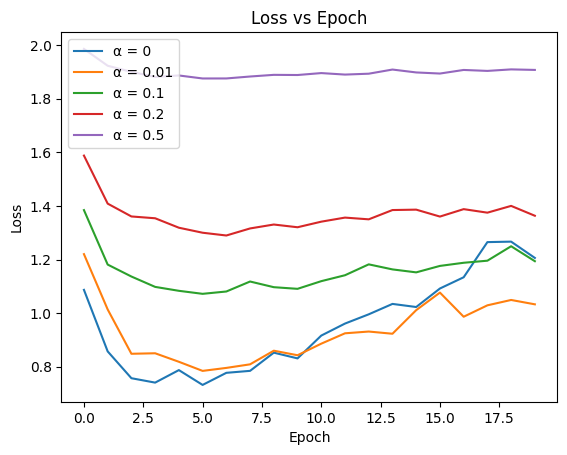

In [9]:
#load loss
train_loss = np.load('./cifar10_cnn/train_loss.npy')
val_loss = np.load('./cifar10_cnn/val_loss.npy')

train_loss2 = np.load('./cifar10_cnn/train_loss2.npy')
val_loss2 = np.load('./cifar10_cnn/val_loss2.npy')

train_loss3 = np.load('./cifar10_cnn/train_loss3.npy')
val_loss3 = np.load('./cifar10_cnn/val_loss3.npy')

train_loss4 = np.load('./cifar10_cnn/train_loss4.npy')
val_loss4 = np.load('./cifar10_cnn/val_loss4.npy')

train_loss5 = np.load('./cifar10_cnn/train_loss5.npy')
val_loss5 = np.load('./cifar10_cnn/val_loss5.npy')


#plot the loss
#plt.plot(train_loss, label='train_loss')
plt.plot(val_loss, label='α = 0')
#plt.plot(train_loss2, label='train_loss2')
plt.plot(val_loss2, label='α = 0.01')
#plt.plot(train_loss3, label='train_loss3')
plt.plot(val_loss3, label='α = 0.1')
#plt.plot(train_loss4, label='train_loss4')
plt.plot(val_loss4, label='α = 0.2')
#plt.plot(train_loss5, label='train_loss5')
plt.plot(val_loss5, label='α = 0.5')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
#plt.savefig('cifar10_cnn/loss.png')
plt.show()

## Plot accuracy

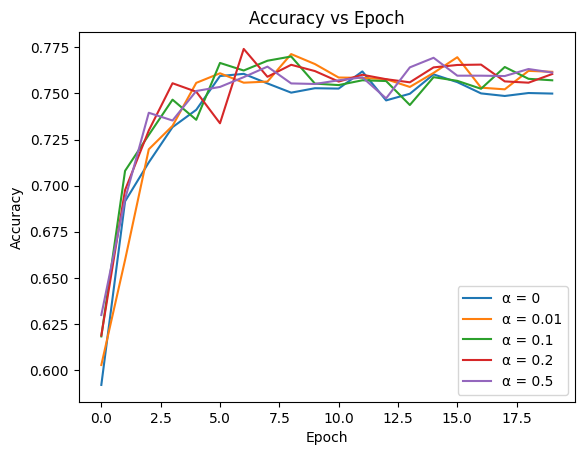

In [10]:
#load the accuracy
acc = np.load('./cifar10_cnn/acc_1.npy')
val_acc = np.load('./cifar10_cnn/val_acc_1.npy')

acc2 = np.load('./cifar10_cnn/acc_2.npy')
val_acc2 = np.load('./cifar10_cnn/val_acc_2.npy')

acc3 = np.load('./cifar10_cnn/acc_3.npy')
val_acc3 = np.load('./cifar10_cnn/val_acc_3.npy')

acc4 = np.load('./cifar10_cnn/acc_4.npy')
val_acc4 = np.load('./cifar10_cnn/val_acc_4.npy')

acc5 = np.load('./cifar10_cnn/acc_5.npy')
val_acc5 = np.load('./cifar10_cnn/val_acc_5.npy')

#plot the accuracy
#plt.plot(acc, label='train_acc')
plt.plot(val_acc, label='α = 0')
#plt.plot(acc2, label='train_acc2')
plt.plot(val_acc2, label='α = 0.01')
#plt.plot(acc3, label='train_acc3')
plt.plot(val_acc3, label='α = 0.1')
#plt.plot(acc4, label='train_acc4')
plt.plot(val_acc4, label='α = 0.2')
#plt.plot(acc5, label='train_acc5')
plt.plot(val_acc5, label='α = 0.5')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
#plt.savefig('cifar10_cnn/acc.png')
plt.show()


In [11]:
#load validation accuracy of top 3
top3_val_acc = np.load('./cifar10_cnn/top3_val_acc_1.npy')
top3_val_acc2 = np.load('./cifar10_cnn/top3_val_acc_2.npy')
top3_val_acc3 = np.load('./cifar10_cnn/top3_val_acc_3.npy')
top3_val_acc4 = np.load('./cifar10_cnn/top3_val_acc_4.npy')
top3_val_acc5 = np.load('./cifar10_cnn/top3_val_acc_5.npy')

#print optimal accuracies of each model
print('Model 1: α = 0')
print('Train accuracy: ', max(acc))
print('Validation accuracy: ', max(val_acc))
print('Top 3 validation accuracy: ', max(top3_val_acc))

print('Model 2 : α = 0.01')
print('Train accuracy: ', max(acc2))
print('Validation accuracy: ', max(val_acc2))
print('Top 3 validation accuracy: ', max(top3_val_acc2))

print('Model 3 : α = 0.1')
print('Train accuracy: ', max(acc3))
print('Validation accuracy: ', max(val_acc3))
print('Top 3 validation accuracy: ', max(top3_val_acc3))

print('Model 4 : α = 0.2')
print('Train accuracy: ', max(acc4))
print('Validation accuracy: ', max(val_acc4))
print('Top 3 validation accuracy: ', max(top3_val_acc4))

print('Model 5 : α = 0.5')
print('Train accuracy: ', max(acc5))
print('Validation accuracy: ', max(val_acc5))
print('Top 3 validation accuracy: ', max(top3_val_acc5))


Model 1: α = 0
Train accuracy:  0.9508799910545349
Validation accuracy:  0.761900007724762
Top 3 validation accuracy:  0.9420999884605408
Model 2 : α = 0.01
Train accuracy:  0.9605000019073486
Validation accuracy:  0.7713000178337097
Top 3 validation accuracy:  0.9412000179290771
Model 3 : α = 0.1
Train accuracy:  0.9549000263214111
Validation accuracy:  0.7699999809265137
Top 3 validation accuracy:  0.9416999816894531
Model 4 : α = 0.2
Train accuracy:  0.9579200148582458
Validation accuracy:  0.7741000056266785
Top 3 validation accuracy:  0.9377999901771545
Model 5 : α = 0.5
Train accuracy:  0.9535800218582153
Validation accuracy:  0.7692999839782715
Top 3 validation accuracy:  0.9348000288009644


## Save trained model weights

In [12]:
#save the trained model (Parameters) so I can use it again without training again
model.save('cifar100_cnn.h5')
#save the trained model (Weights) so I can use it again without training again
model.save_weights('cifar100_cnn_weights.h5')


## Load the trained Model

In [ ]:
#load the trained model (Parameters) so I can use it again without training again
#model = keras.models.load_model('cifar100_cnn.h5')

#load the trained model (Weights) so I can use it again without training again
#model.load_weights('cifar100_cnn_weights.h5')